# Requirements

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tf_keras.preprocessing import sequence
import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns

# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the primary objective is to use Long Short-Term Memory (LSTM) networks for time series forecasting in order to predict the current **mean temperature** in the city of Delhi. To accomplish this use data from the past three days, which includes information such as the **mean temperature**, **humidity**, **wind speed**, and **mean pressure**. The goal is to employ LSTM, a type of recurrent neural network, to effectively forecast the future mean temperature based on the provided historical data.

**Note: You are required to perform this laboratory assignment on your local machine.**

## The Climate Dataset

## Downloading the Climate Dataset

## Exploring the Climate Dataset
This dataset consists of daily weather records for the city of Delhi spanning a period of 4 years (from 2013 to 2017). The dataset includes the following attributes:

- date - date in the format YYYY-MM-DD,
- meantemp - mean temperature averaged from multiple 3-hour intervals in a day,
- humidity - humidity value for the day (measured in grams of water vapor per cubic meter volume of air),
- wind_speed - wind speed measured in kilometers per hour, and
- meanpressure - pressure reading of the weather (measured in atm).

*Note: The dataset is complete, with no missing values in any of its entries.*

Load the dataset into a `pandas` data frame.

In [ ]:
df = pd.read_csv("/content/climate-data (1).csv")
df

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


Explore the dataset using visualizations of your choice.

In [ ]:
df["date"] = pd.to_datetime(df["date"])
df.set_index(keys=["date"], inplace=True)
df.sort_index(inplace=True)
df

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762
2016-12-30,14.095238,89.666667,6.266667,1017.904762


In [ ]:
df.isnull().sum()


,0
meantemp,0
humidity,0
wind_speed,0
meanpressure,0


<Axes: xlabel='date', ylabel='meanpressure'>

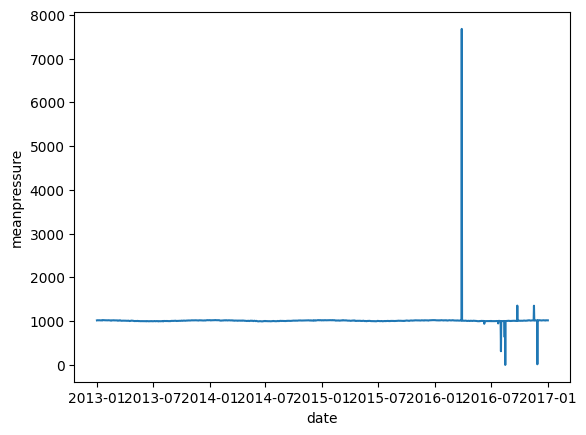

In [ ]:
sns.lineplot(df["meanpressure"])


<Axes: >

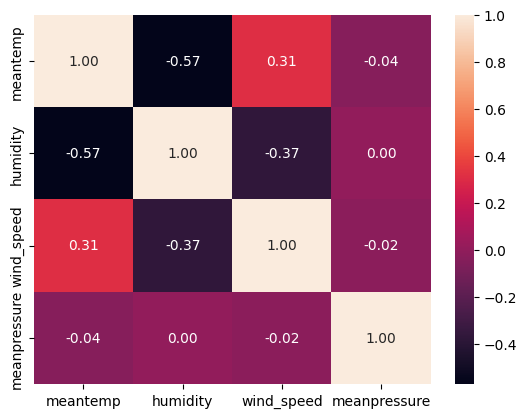

In [ ]:
sns.heatmap(df.corr(), annot=True, fmt=".2f")


## Feauture Extraction
Apply a lag of one, two, and three days to each feature, creating a set of features representing the meteorological conditions from the previous three days. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

*Be careful when extracting the features. For each day, ensure that features are obtained sequentially, starting with those from 3 days ago, followed by features from 2 days ago, and finally, features from 1 day ago. This becomes crucial when reshaping the train and test sets later on.*

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [ ]:
lags = range(3, 0, -1)
list(lags)

[3, 2, 1]

In [ ]:
features = ["meantemp", "humidity", "wind_speed"]
target = "meanpressure"

In [ ]:
df.drop(columns=features, inplace=True)


In [ ]:
df

,meanpressure
date,
2013-01-01,1015.666667
2013-01-02,1017.800000
2013-01-03,1018.666667
2013-01-04,1017.166667
2013-01-05,1016.500000
...,...
2016-12-28,1015.565217
2016-12-29,1016.904762
2016-12-30,1017.904762


In [ ]:
for lag in lags:
    for column in df:
        df[f"{column}_{lag}"] = df[column].shift(lag)
df

,meanpressure,meanpressure_3,meanpressure_2,meanpressure_3_2,meanpressure_1,meanpressure_3_1,meanpressure_2_1,meanpressure_3_2_1
date,,,,,,,,
2013-01-01,1015.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,1017.800000,NaN,NaN,NaN,1015.666667,NaN,NaN,NaN
2013-01-03,1018.666667,NaN,1015.666667,NaN,1017.800000,NaN,NaN,NaN
2013-01-04,1017.166667,1015.666667,1017.800000,NaN,1018.666667,NaN,1015.666667,NaN
2013-01-05,1016.500000,1017.800000,1018.666667,NaN,1017.166667,1015.666667,1017.800000,NaN
...,...,...,...,...,...,...,...,...
2016-12-28,1015.565217,1014.350000,1016.952381,1014.250000,1017.200000,1011.318182,1014.350000,1016.142857
2016-12-29,1016.904762,1016.952381,1017.200000,1011.318182,1015.565217,1014.350000,1016.952381,1014.250000
2016-12-30,1017.904762,1017.200000,1015.565217,1014.350000,1016.904762,1016.952381,1017.200000,1011.318182


In [ ]:
df.dropna(axis=0, inplace=True)


In [ ]:
df

,meanpressure,meanpressure_3,meanpressure_2,meanpressure_3_2,meanpressure_1,meanpressure_3_1,meanpressure_2_1,meanpressure_3_2_1
date,,,,,,,,
2013-01-07,1020.000000,1017.166667,1016.500000,1017.800000,1018.000000,1018.666667,1017.166667,1015.666667
2013-01-08,1018.714286,1016.500000,1018.000000,1018.666667,1020.000000,1017.166667,1016.500000,1017.800000
2013-01-09,1017.000000,1018.000000,1020.000000,1017.166667,1018.714286,1016.500000,1018.000000,1018.666667
2013-01-10,1015.666667,1020.000000,1018.714286,1016.500000,1017.000000,1018.000000,1020.000000,1017.166667
2013-01-11,1016.142857,1018.714286,1017.000000,1018.000000,1015.666667,1020.000000,1018.714286,1016.500000
...,...,...,...,...,...,...,...,...
2016-12-28,1015.565217,1014.350000,1016.952381,1014.250000,1017.200000,1011.318182,1014.350000,1016.142857
2016-12-29,1016.904762,1016.952381,1017.200000,1011.318182,1015.565217,1014.350000,1016.952381,1014.250000
2016-12-30,1017.904762,1017.200000,1015.565217,1014.350000,1016.904762,1016.952381,1017.200000,1011.318182


## Dataset Splitting
Partition the dataset into training and testing sets with an 90:10 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [ ]:
X, y = df.drop(columns=[target]), df[target]


In [ ]:
X

,meanpressure_3,meanpressure_2,meanpressure_3_2,meanpressure_1,meanpressure_3_1,meanpressure_2_1,meanpressure_3_2_1
date,,,,,,,
2013-01-07,1017.166667,1016.500000,1017.800000,1018.000000,1018.666667,1017.166667,1015.666667
2013-01-08,1016.500000,1018.000000,1018.666667,1020.000000,1017.166667,1016.500000,1017.800000
2013-01-09,1018.000000,1020.000000,1017.166667,1018.714286,1016.500000,1018.000000,1018.666667
2013-01-10,1020.000000,1018.714286,1016.500000,1017.000000,1018.000000,1020.000000,1017.166667
2013-01-11,1018.714286,1017.000000,1018.000000,1015.666667,1020.000000,1018.714286,1016.500000
...,...,...,...,...,...,...,...
2016-12-28,1014.350000,1016.952381,1014.250000,1017.200000,1011.318182,1014.350000,1016.142857
2016-12-29,1016.952381,1017.200000,1011.318182,1015.565217,1014.350000,1016.952381,1014.250000
2016-12-30,1017.200000,1015.565217,1014.350000,1016.904762,1016.952381,1017.200000,1011.318182


In [ ]:
y

,meanpressure
date,
2013-01-07,1020.000000
2013-01-08,1018.714286
2013-01-09,1017.000000
2013-01-10,1015.666667
2013-01-11,1016.142857
...,...
2016-12-28,1015.565217
2016-12-29,1016.904762
2016-12-30,1017.904762


In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.20, shuffle=False)


In [ ]:
scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)
train_y = scaler.fit_transform(train_y.values.reshape(-1, 1))

## Feauture Scaling
Scale the extracted features using an appropriate scaler.

In [ ]:
lag = 3
(train_X.shape[0], lag, (train_X.shape[1] // lag))

(1164, 3, 2)

In [ ]:
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

In [ ]:
model = Sequential([
    LSTM(100, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True),
    LSTM(64, dropout=0.1, recurrent_dropout=0.1),
    Dense(1, activation="relu")
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(
    loss="mean_squared_error",
    optimizer="adam",
    metrics=[
        "mean_absolute_error",
        "mean_squared_error",
    ]
)


In [ ]:
print(df.shape)


(1456, 8)


## Feature Reshaping

Reshape the feature dimensions into the shape `(samples, timesteps, features)`.

## Long Short-Term Memory (LSTM) Network
Build a Long Short-Term Memory (LSTM) Network for forecasting the current **mean temperature** based on the extracted features from the previous three days.

Define the forecasting model using the **Keras Sequential API** (`keras.models.Sequential`), incorporating one or more LSTM layers along with additional relevant layers (`keras.layers`). Be cautious when specifying the configuration of the final layer to ensure proper model output for the forecasting task.

In [ ]:
history = model.fit(train_X, train_y, batch_size=8, validation_split=0.2, epochs=4, shuffle=False)

Epoch 1/4
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.1760 - mean_absolute_error: 0.2939 - mean_squared_error: 0.1760 - val_loss: 0.0475 - val_mean_absolute_error: 0.1889 - val_mean_squared_error: 0.0475
Epoch 2/4
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0286 - mean_absolute_error: 0.1418 - mean_squared_error: 0.0286 - val_loss: 0.0709 - val_mean_absolute_error: 0.2355 - val_mean_squared_error: 0.0709
Epoch 3/4
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0350 - mean_absolute_error: 0.1517 - mean_squared_error: 0.0350 - val_loss: 0.0707 - val_mean_absolute_error: 0.2349 - val_mean_squared_error: 0.0707
Epoch 4/4
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0357 - mean_absolute_error: 0.1503 - mean_squared_error: 0.0357 - val_loss: 0.0554 - val_mean_absolute_error: 0.2068 - val_mean_squared_error: 0.0554


In [ ]:
# Write your code here. Add as many boxes as you need.

Compile the previously defined model specifying **loss function** (`keras.losses`), **optimizer** (`keras.optimizers`) and **evaluation metrics** (`keras.metics`).

In [ ]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 100)              │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          42,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 249,317 (973.90 KB)

 Trainable params: 83,105 (324.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 166,212 (649.27 KB)

Train the model on the training set, specifying the **batch size** and **number of epochs** for the training process. Allocate 20% of the samples for **validation**, and ensure that the dataset remains **unshuffled** during training.

In [ ]:
# Write your code here. Add as many boxes as you need.

Create a line plot illustrating both the **training** and **validation loss** over the training epochs.

<Axes: >

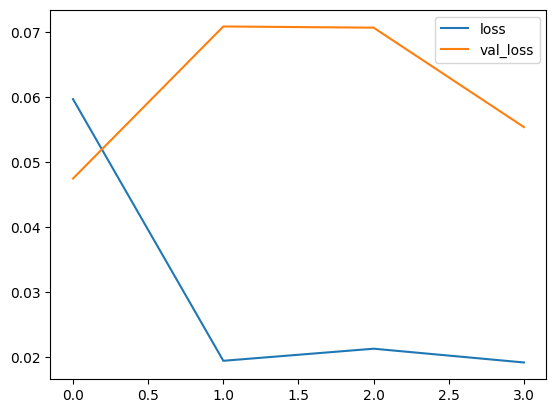

In [ ]:
sns.lineplot(history.history["loss"], label="loss")
sns.lineplot(history.history["val_loss"], label="val_loss")

Use the trained model to make predictions for the test set.

In [ ]:
preds = model.predict(test_X)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


In [ ]:
preds = scaler.inverse_transform(preds)

In [ ]:
mean_squared_error(preds, test_y), mean_absolute_error(preds, test_y), r2_score(preds, test_y)

(162273.93066841198, 40.77406007530243, -5547.010281852605)